## Day 24 Lecture 2 Assignment

In this assignment, we will build our a more complex logistic regression model, this time on both numeric and categorical data. We will use the Chicago traffic crashes dataset loaded below and analyze the model generated for this dataset.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve



In [2]:
def missingness_summary(df, print_log=False, sort='none'):
    summary = df.apply(lambda x: x.isna().sum() / x.shape[0])
    
    if print_log == True:
        if sort == 'none':
            print(summary)
        elif sort == 'ascending':
            print(summary.sort_values())
        elif sort == 'descending':
            print(summary.sort_values(ascending=False))
        else:
            print('Invalid value for sort parameter.')
        
    return summary

In [3]:
crash_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/traffic_crashes_chicago.csv')

In [4]:
crash_data['DAMAGE'].value_counts()



OVER $1,500      209921
$501 - $1,500    112592
$500 OR LESS      50072
Name: DAMAGE, dtype: int64

First, create a binary response column by modifying the "DAMAGE" column. Consider "OVER \$1500" to be the positive class, and under \$1500 to be the negative class.

In [5]:
# answer goes here
crash_data['is_1500+'] = (crash_data['DAMAGE'] == 'OVER $1,500').astype(int)
crash_data['is_1500+']



0         1
1         1
2         0
3         0
4         0
         ..
372580    0
372581    1
372582    1
372583    1
372584    1
Name: is_1500+, Length: 372585, dtype: int32

Using the code from Day 21, Lecture 1 as a starting point, devise an appropriate way to address missing values. You have a lot of freedom here; we will proceed by taking the following steps:

- Dropping all columns with more than 5% missing data
- Imputing the median for numeric columns with less than 5% missing data (except for STREET_NO; imputing it in this manner would not make any sense)
- Dropping rows with missing data for categorical columns that have less than 5% missing data

In [6]:
crash_data.isna().mean()

RD_NO                            0.000000
CRASH_DATE                       0.000000
POSTED_SPEED_LIMIT               0.000000
TRAFFIC_CONTROL_DEVICE           0.000000
DEVICE_CONDITION                 0.000000
WEATHER_CONDITION                0.000000
LIGHTING_CONDITION               0.000000
FIRST_CRASH_TYPE                 0.000000
TRAFFICWAY_TYPE                  0.000000
LANE_CNT                         0.467107
ALIGNMENT                        0.000000
ROADWAY_SURFACE_COND             0.000000
ROAD_DEFECT                      0.000000
REPORT_TYPE                      0.023012
CRASH_TYPE                       0.000000
INTERSECTION_RELATED_I           0.779457
NOT_RIGHT_OF_WAY_I               0.953917
HIT_AND_RUN_I                    0.722423
DAMAGE                           0.000000
DATE_POLICE_NOTIFIED             0.000000
PRIM_CONTRIBUTORY_CAUSE          0.000000
SEC_CONTRIBUTORY_CAUSE           0.000000
STREET_NO                        0.000000
STREET_DIRECTION                 0

In [7]:
col_list_missing = []
for col in crash_data:
    if crash_data[col].isna().mean() >= 0.05:
        col_list_missing.append(col)
crash_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372585 entries, 0 to 372584
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   RD_NO                          372585 non-null  object 
 1   CRASH_DATE                     372585 non-null  object 
 2   POSTED_SPEED_LIMIT             372585 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE         372585 non-null  object 
 4   DEVICE_CONDITION               372585 non-null  object 
 5   WEATHER_CONDITION              372585 non-null  object 
 6   LIGHTING_CONDITION             372585 non-null  object 
 7   FIRST_CRASH_TYPE               372585 non-null  object 
 8   TRAFFICWAY_TYPE                372585 non-null  object 
 9   LANE_CNT                       198548 non-null  float64
 10  ALIGNMENT                      372585 non-null  object 
 11  ROADWAY_SURFACE_COND           372585 non-null  object 
 12  ROAD_DEFECT                   

In [8]:
# answer goes here
crash_data = crash_data.drop(columns=col_list_missing, axis=1)
col_list_missing

['LANE_CNT',
 'INTERSECTION_RELATED_I',
 'NOT_RIGHT_OF_WAY_I',
 'HIT_AND_RUN_I',
 'PHOTOS_TAKEN_I',
 'STATEMENTS_TAKEN_I',
 'DOORING_I',
 'WORK_ZONE_I',
 'WORK_ZONE_TYPE',
 'WORKERS_PRESENT_I']

In [9]:
crash_data = crash_data.dropna()
crash_data.isna().sum()

RD_NO                            0
CRASH_DATE                       0
POSTED_SPEED_LIMIT               0
TRAFFIC_CONTROL_DEVICE           0
DEVICE_CONDITION                 0
WEATHER_CONDITION                0
LIGHTING_CONDITION               0
FIRST_CRASH_TYPE                 0
TRAFFICWAY_TYPE                  0
ALIGNMENT                        0
ROADWAY_SURFACE_COND             0
ROAD_DEFECT                      0
REPORT_TYPE                      0
CRASH_TYPE                       0
DAMAGE                           0
DATE_POLICE_NOTIFIED             0
PRIM_CONTRIBUTORY_CAUSE          0
SEC_CONTRIBUTORY_CAUSE           0
STREET_NO                        0
STREET_DIRECTION                 0
STREET_NAME                      0
BEAT_OF_OCCURRENCE               0
NUM_UNITS                        0
MOST_SEVERE_INJURY               0
INJURIES_TOTAL                   0
INJURIES_FATAL                   0
INJURIES_INCAPACITATING          0
INJURIES_NON_INCAPACITATING      0
INJURIES_REPORTED_NO

Finally, choose a few numeric and categorical features (2-3 of each) to include in the model. (You can definitely include more than this, but too many features, especially categorical ones, will most likely lead to convergence issues). One hot encode the chosen categorical features, being sure to omit one of the categories (which will serve as a "reference" level) to avoid perfect multicollinearity.

Again, you have a lot of freedom here; we will proceed with the following features, dropping the most commonly occurring category for the two categorical variables ("CLEAR" for weather, "REAR END" for first crash type):
POSTED_SPEED_LIMIT, WEATHER_CONDITION, INJURIES_TOTAL, FIRST_CRASH_TYPE

In [10]:
# answer goes here
feat_col = ['POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'INJURIES_TOTAL', 'FIRST_CRASH_TYPE', 'is_1500+']
crash = crash_data[feat_col]
crash = crash[crash['WEATHER_CONDITION'] != 'CLEAR']
crash = crash[crash['FIRST_CRASH_TYPE'] != 'REAR END']

In [11]:
crash = pd.get_dummies(crash, columns=['WEATHER_CONDITION', 'FIRST_CRASH_TYPE'])

Split the data into train and test, with 80% training and 20% testing. By default, the LR output from statsmodels does not include an intercept terms; add a constant column to the training data so that an intercept term is calculated for the LR model (hint: sm.add_constant() is a useful function to accomplish this).

In [13]:
# answer goes here
X = crash.drop(columns=['is_1500+'])
y = crash['is_1500+']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [14]:
y

10        1
18        1
21        0
22        0
26        0
         ..
372534    1
372541    1
372544    1
372545    1
372559    0
Name: is_1500+, Length: 56321, dtype: int32

In [15]:
X.melt()

,variable,value
0,POSTED_SPEED_LIMIT,30.0
1,POSTED_SPEED_LIMIT,25.0
2,POSTED_SPEED_LIMIT,30.0
3,POSTED_SPEED_LIMIT,30.0
4,POSTED_SPEED_LIMIT,25.0
...,...,...
1633304,FIRST_CRASH_TYPE_TURNING,1.0
1633305,FIRST_CRASH_TYPE_TURNING,0.0
1633306,FIRST_CRASH_TYPE_TURNING,1.0
1633307,FIRST_CRASH_TYPE_TURNING,0.0


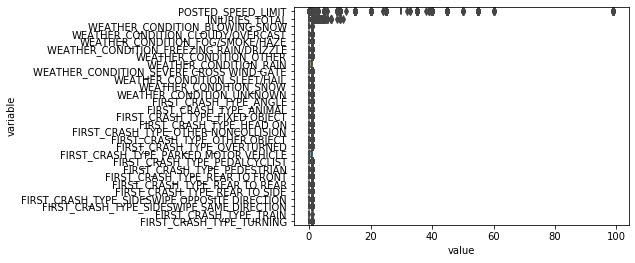

In [16]:
sns.boxplot('value', 'variable', data=X.select_dtypes(include='number').melt())

Fit the logistic regression model using the statsmodels package and print out the coefficient summary. Which variables (in particular, which categories of our categorical variables) appear to be the most important, and what effect do they have on the probability of a crash resulting in $1500 or more in damages?

In [17]:
# answer goes here
model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
model.score(X_train, y_train)

0.6268421519886364

In [19]:
model.score(X_test, y_test)

0.6200621393697292

In [20]:
cols = X_train.columns
coef_df = pd.DataFrame(data=model.coef_, columns=cols)
coef_df.T

,0
POSTED_SPEED_LIMIT,0.014706
INJURIES_TOTAL,0.841523
WEATHER_CONDITION_BLOWING SNOW,-0.083811
WEATHER_CONDITION_CLOUDY/OVERCAST,-0.149785
WEATHER_CONDITION_FOG/SMOKE/HAZE,-0.011063
WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,0.390454
WEATHER_CONDITION_OTHER,0.005648
WEATHER_CONDITION_RAIN,-0.128614
WEATHER_CONDITION_SEVERE CROSS WIND GATE,0.123626
WEATHER_CONDITION_SLEET/HAIL,-0.065373


As we did on the previous exercise, make predictions on the test set and join them to the corresponding true outcomes, then use the *calibration_curve* function in scikit learn to plot a calibration curve. Is the model well-calibrated?

In [21]:
X_test

,POSTED_SPEED_LIMIT,INJURIES_TOTAL,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLOUDY/OVERCAST,WEATHER_CONDITION_FOG/SMOKE/HAZE,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,WEATHER_CONDITION_OTHER,WEATHER_CONDITION_RAIN,WEATHER_CONDITION_SEVERE CROSS WIND GATE,WEATHER_CONDITION_SLEET/HAIL,...,FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE,FIRST_CRASH_TYPE_PEDALCYCLIST,FIRST_CRASH_TYPE_PEDESTRIAN,FIRST_CRASH_TYPE_REAR TO FRONT,FIRST_CRASH_TYPE_REAR TO REAR,FIRST_CRASH_TYPE_REAR TO SIDE,FIRST_CRASH_TYPE_SIDESWIPE OPPOSITE DIRECTION,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,FIRST_CRASH_TYPE_TRAIN,FIRST_CRASH_TYPE_TURNING
354841,25,0.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
228065,20,0.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
177102,30,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
247053,30,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
44341,25,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231213,35,0.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
65887,30,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
203424,25,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
355558,25,0.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [22]:
# answer goes here
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_mat, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
conf_df



,Predicted 0,Predicted 1
Actual 0,563,3974
Actual 1,306,6422


In [24]:
coef_df = pd.DataFrame({'feat': X.columns, 'coef': model.coef_.flatten()})
coef_df.head()

,feat,coef
0,POSTED_SPEED_LIMIT,0.014706
1,INJURIES_TOTAL,0.841523
2,WEATHER_CONDITION_BLOWING SNOW,-0.083811
3,WEATHER_CONDITION_CLOUDY/OVERCAST,-0.149785
4,WEATHER_CONDITION_FOG/SMOKE/HAZE,-0.011063


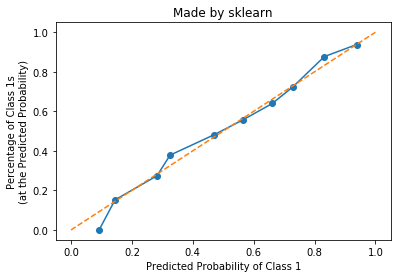

In [26]:
y_pred_prob = model.predict_proba(X_test)[:, 1]

y, x = calibration_curve(y_test, y_pred_prob, n_bins=10)

plt.plot(x, y, '-o')
plt.plot([0,1], [0,1], '--')
plt.title('Made by sklearn')
plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Percentage of Class 1s\n(at the Predicted Probability)')
plt.show()